In [1]:
import numpy as np
import pandas as pd
import torch
import os

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [ ]:
import grelu.resources

In [2]:
model = grelu.resources.load_model(
    project="borzoi",
    model_name="human_fold0",
)
model

/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: adamklie (carter-comp-bio). Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_fold0:latest, 711.00MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:18.0


LightningModel(
  (model): BorzoiModel(
    (embedding): BorzoiTrunk(
      (conv_tower): BorzoiConvTower(
        (blocks): ModuleList(
          (0): Stem(
            (conv): Conv1d(4, 512, kernel_size=(15,), stride=(1,), padding=same)
            (act): Activation(
              (layer): Identity()
            )
            (pool): Pool(
              (layer): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            )
          )
          (1): ConvBlock(
            (norm): Norm(
              (layer): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (conv): Conv1d(512, 608, kernel_size=(5,), stride=(1,), padding=same)
            (act): Activation(
              (layer): GELU(approximate='none')
            )
            (pool): Pool(
              (layer): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            )
            (dropout): Dropout(
              (la

In [3]:
model.data_params.keys()

dict_keys(['tasks', 'train_seq_len', 'train_label_len', 'train_genome', 'train_bin_size'])

In [4]:
for key in model.data_params.keys():
    if key !="tasks":
        print(key, model.data_params[key])

train_seq_len 524288
train_label_len 16384
train_genome hg38
train_bin_size 32


In [5]:
tasks = pd.DataFrame(model.data_params['tasks'])
tasks.head(3)

,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
0,CNhs10608+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,1,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
1,CNhs10608-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,0,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
2,CNhs10610+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,3,CAGE:SABiosciences XpressRef Human Universal T...,CAGE,SABiosciences XpressRef Human Universal Total ...


In [10]:
borzoi = model.model

In [17]:
import seqdata as sd

In [18]:
path_peaks = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/K562_ATAC-seq_peaks.zarr"

In [19]:
peaks = sd.open_zarr(path_peaks)

In [58]:
peaks_df = peaks[["chrom", "chromStart", "chromEnd"]].to_pandas().reset_index(drop=True)
peaks_df = peaks_df[:32]

In [59]:
input_len = model.data_params["train_seq_len"]

In [60]:
peaks_df["mid"] = (peaks_df["chromStart"] + peaks_df["chromEnd"]) // 2
peaks_df["start"] = peaks_df["mid"] - input_len // 2
peaks_df["end"] = peaks_df["mid"] + input_len // 2

In [62]:
import grelu.sequence.format

input_seqs = grelu.sequence.format.convert_input_type(
    peaks_df[['chrom', 'start', 'end']],
    output_type="strings",
    genome="hg38"
)
input_seq = input_seqs[0]

len(input_seq)

524288

In [44]:
%%time
preds = model.predict_on_seqs(input_seq, device="cpu")
preds.shape

CPU times: user 1min 18s, sys: 6.6 s, total: 1min 24s
Wall time: 24 s


(1, 7611, 6144)

In [47]:
output_intervals = model.input_intervals_to_output_intervals(peaks_df)
output_intervals

,chrom,start,end,mid
0,chr1,99930425,100127033,100028729
1,chr1,99930425,100127033,100028729
2,chr1,99930425,100127033,100028729
3,chr1,99930425,100127033,100028729
4,chr1,99930425,100127033,100028729
5,chr1,99936346,100132954,100034650
6,chr1,99938792,100135400,100037096
7,chr1,99938792,100135400,100037096
8,chr1,99938792,100135400,100037096
9,chr1,99940113,100136721,100038417


In [48]:
import grelu.visualize
%matplotlib inline

In [52]:
tasks_to_plot = tasks[(tasks["sample"].str.contains("K562")) & (tasks["description"] == ("DNASE:K562"))].index.tolist()

In [53]:
task_names = tasks.description[tasks_to_plot].tolist() # Description of these tracks from the `tasks` dataframe

print(tasks_to_plot)
print(task_names)

[1397, 1398, 1399, 1901]
['DNASE:K562', 'DNASE:K562', 'DNASE:K562', 'DNASE:K562']


In [71]:
6144*32

196608

In [63]:
output_start = peaks_df.chromStart[0]
output_end = peaks_df.chromEnd[0]
output_len = output_end - output_start

In [70]:
preds.shape

(1, 7611, 6144)

In [69]:
preds[0, tasks_to_plot, :].shape

(4, 6144)

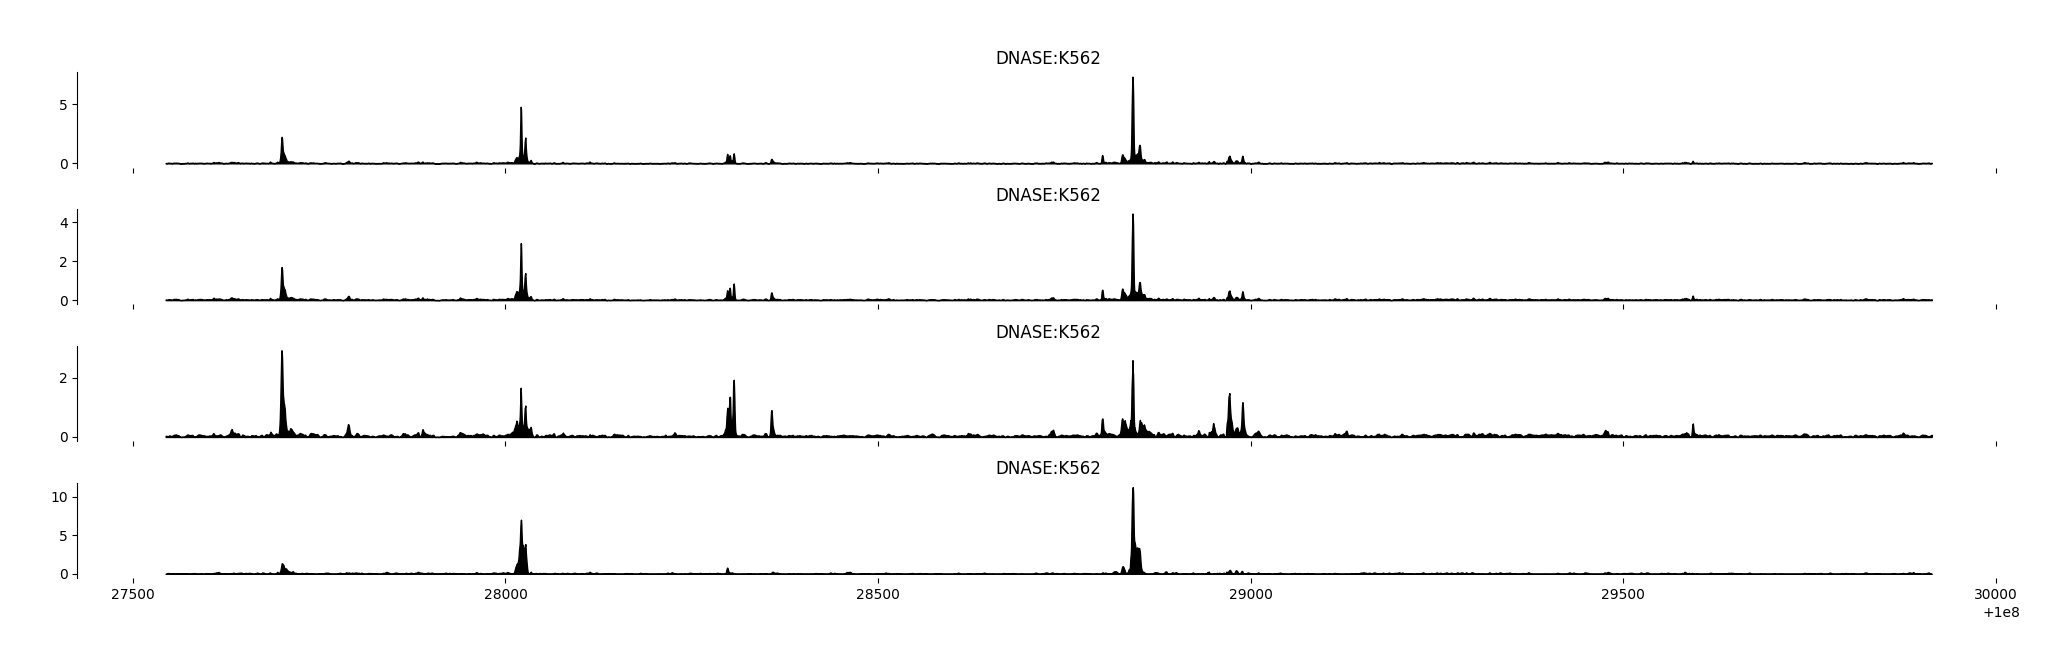

In [64]:
fig = grelu.visualize.plot_tracks(
    preds[0, tasks_to_plot, :], # Outputs to plot
    start_pos=output_start, # Start coordinate for the x-axis label
    end_pos=output_end, # End coordinate for the x-axis label
    titles=task_names, # titles for each track
    figsize=(20, 6), # width, height
)

In [65]:
import pyBigWig
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tracks(tracks, interval, height=1.5, colors=None):
  _, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  if not isinstance(axes, np.ndarray):
    axes = [axes]
  for ax, (title, y) in zip(axes, tracks.items()):
    if colors is not None:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y, color=colors[title])
    else:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(f"{interval['chrom']}:{interval['start']}-{interval['end']}")
  plt.tight_layout()

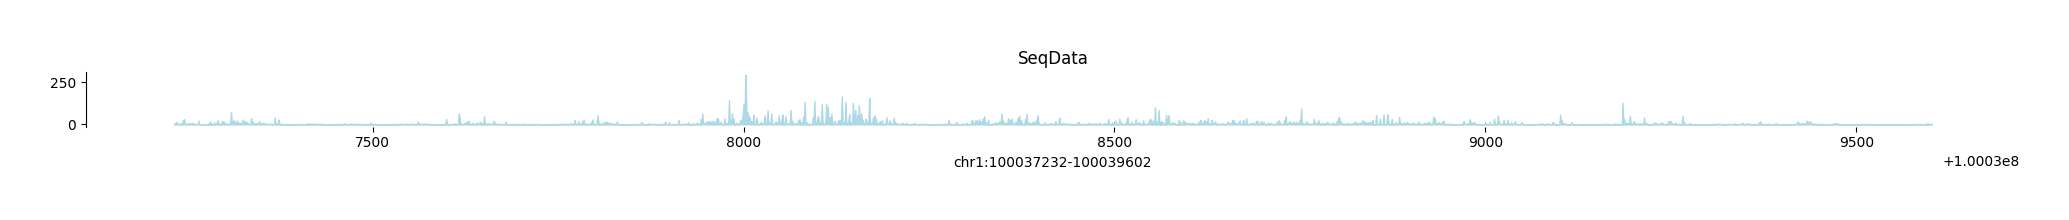

In [66]:
# Get data
seq_num = 10
ser = peaks[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
sdata_vals = peaks["cov"][seq_num].values.squeeze()
chrom = ser["chrom"]
chromStart = ser["chromStart"]
chromEnd = ser["chromEnd"]
interval = dict(chrom=chrom, start=chromStart, end=chromEnd)
tracks = {
    "SeqData": sdata_vals,
}
colors = {
    "SeqData": "lightblue",
}

# Plot tracks
plot_tracks(
    tracks=tracks,
    interval=interval,
    colors=colors
)